# Convert Last Row Tracking Data to Metrica Tracking Data Format
To use the function developped with Metrica Tracking Data, I have to convert Last Row ones.

## Import Data

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import os

Let's import Last Row sample data

In [37]:
LR_data = pd.read_csv('data_inputs/liverpool_analytics_2019.csv')
LR_data.head()

,Unnamed: 0,bgcolor,dx,dy,edgecolor,frame,play,player,player_num,team,x,y,z
0,0,NaN,0.000000,0.000000,NaN,0,Liverpool [3] - 0 Bournemouth,0,NaN,NaN,46.394558,11.134454,0.0
1,1,NaN,0.185745,1.217580,NaN,1,Liverpool [3] - 0 Bournemouth,0,NaN,NaN,46.580302,12.352034,0.0
2,2,NaN,0.178659,1.171133,NaN,2,Liverpool [3] - 0 Bournemouth,0,NaN,NaN,46.758961,13.523166,0.0
3,3,NaN,0.171573,1.124685,NaN,3,Liverpool [3] - 0 Bournemouth,0,NaN,NaN,46.930535,14.647852,0.0
4,4,NaN,0.164488,1.078238,NaN,4,Liverpool [3] - 0 Bournemouth,0,NaN,NaN,47.095022,15.726090,0.0


In [8]:
LR_events = pd.read_csv('data_inputs/liverpool_analytics_2019_passes.csv')

Let's import Metrica Sample data

In [2]:
from metrica_football_func import Metrica_IO as mio

In [3]:
tracking_home,tracking_away,events=mio.read_match_data('data_inputs/metrica_football',2)

Reading team: home
Reading team: away


In [4]:
tracking_home.head()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Convert coordinates to meters

In [134]:
def convert_x(row):
    return((row['x']-50)/100*106)

def convert_y(row):
    return((row['y']-50)/100*68)

## Convert a play

In [167]:
def convert_play(data,play):
    
    play_data = data.query('play==@play')
    
    # find home and away team
    home_team_name = 'attack' #consider that Liverpool is the home team
    away_team_name = 'defense'
    
    
    # create home team players columns and collect players num
    home_play_data = play_data.query('team==@home_team_name')
    home_team_players = home_play_data.player.unique()
    home_team_players_columns = {}
    players_num = {}
    
    for player in home_team_players:
        
        player_data = home_play_data.query('player==@player')
        player_x = player_data.x.values
        player_y = player_data.y.values
        player_num = player_data.player_num.values[0]

        home_team_players_columns['Home_'+str(player)+'_x'] = player_x
        home_team_players_columns['Home_'+str(player)+'_y'] = player_y
        
        players_num[str(player)] = player_num
        
    # create away team players columns
    away_play_data = play_data.query('team==@away_team_name')
    away_team_players = away_play_data.player.unique()
    away_team_players_columns = {}
    
    for player in away_team_players:
        
        player_data = away_play_data.query('player==@player')
        player_x = player_data.x.values
        player_y = player_data.y.values
        player_num = player_data.player_num.values[0]

        away_team_players_columns['Away_'+str(player)+'_x'] = player_x
        away_team_players_columns['Away_'+str(player)+'_y'] = player_y
        
        players_num[str(player)] = player_num
    
    # creat ball columns
    ball_play_data = play_data[play_data.team.isna()]
    ball_x = ball_play_data.x
    ball_y = ball_play_data.y
    
    home_team_players_columns['ball_x'] = ball_x
    home_team_players_columns['ball_y'] = ball_y
    away_team_players_columns['ball_x'] = ball_x
    away_team_players_columns['ball_y'] = ball_y
    
    # frame column
    frame = ball_play_data.frame.values
    home_team_players_columns['Frame'] = frame
    away_team_players_columns['Frame'] = frame
    
    # even if we don't know the period we add a column to have the same format
    period = [1]*len(frame)
    home_team_players_columns['Period'] = period
    away_team_players_columns['Period'] = period
    
    # Time column (frame*0.05 because 20fps)
    time = [f*0.05 for f in frame]
    home_team_players_columns['Time [s]'] = time
    away_team_players_columns['Time [s]'] = time

    tracking_home = pd.DataFrame.from_dict(home_team_players_columns)
    tracking_away = pd.DataFrame.from_dict(away_team_players_columns)
    
    tracking_home.set_index('Frame',inplace=True)
    tracking_away.set_index('Frame',inplace=True)
    
    players_num = pd.DataFrame(players_num,index=[i for i in range(len(players_num))])
    players_num = players_num.iloc[0]
    
    return(tracking_home,tracking_away,players_num)

## Convert all plays

In [173]:
def convert_all_plays(data):
    new_data = data.copy()
    new_data['x'] = data.apply(convert_x,axis=1)
    new_data['y'] = data.apply(convert_y,axis=1)
    
    for play in new_data.play.unique():
        tracking_home,tracking_away,players_num = convert_play(new_data,play)
        # create a folder for this play
        os.mkdir('data_inputs/liverpool_analytics/'+play.replace(' ','_'))
        tracking_home.to_csv('data_inputs/liverpool_analytics/'+play.replace(' ','_')+'/tracking_home.csv')
        tracking_away.to_csv('data_inputs/liverpool_analytics/'+play.replace(' ','_')+'/tracking_away.csv')
        players_num.to_csv('data_inputs/liverpool_analytics/'+play.replace(' ','_')+'/players_num.csv')
        
    print('Done')
    
convert_all_plays(LR_data)

Done


## Convert events data

In [10]:
LR_events.head()

,Unnamed: 0,from_team,from_x,from_y,from_frame,from_player_num,to_team,to_x,to_y,to_frame,to_player_num,play
0,0,attack,46.394558,11.134454,0,10.0,attack,48.844160,27.191910,22.0,8.0,Liverpool [3] - 0 Bournemouth
1,1,attack,51.813185,28.611598,42,8.0,attack,85.565258,30.767056,108.0,9.0,Liverpool [3] - 0 Bournemouth
2,2,attack,85.565258,30.767056,108,9.0,attack,86.219036,33.236389,118.0,11.0,Liverpool [3] - 0 Bournemouth
3,0,attack,36.054422,68.277311,16,4.0,attack,82.955888,73.003584,78.0,10.0,Bayern 0 - [1] Liverpool
4,0,attack,47.429230,15.842044,14,26.0,attack,28.497923,7.131785,42.0,10.0,Fulham 0 - [1] Liverpool


In [9]:
events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58


In [34]:
def convert_from_x(row):
    return((row['from_x']-50)/100*106)

def convert_from_y(row):
    return((row['from_y']-50)/100*68)

def convert_to_x(row):
    return((row['to_x']-50)/100*106)

def convert_to_y(row):
    return((row['to_y']-50)/100*68)

In [31]:
def convert_events_play(data,play):
    
    #keep only attack data
    play_data = data.query('from_team=="attack"')
    play_data = data.query('play==@play')
    
    # find home and away team
    home_team_name = 'attack' #consider that Liverpool is the home team
    away_team_name = 'defense'
    
    # initialise dataframe
    df = {}
    # create Team column
    df['Team'] = ['Home']*len(play_data)
    # create Type column
    df['Type'] = ['PASS']*len(play_data)
    # create Subtype column
    df['Subtype'] = [None]*len(play_data)
    # create Period column (set to 1 arbitrarly)
    df['Period'] = [1]*len(play_data)
    # create Start Frame column
    df['Start Frame'] = play_data.from_frame.values
    # create End Frame column
    df['End Frame'] = play_data.to_frame.values
    # create Start Time [s] column
    df['Start Time [s]'] = play_data.from_frame.values*0.05
    # create End Time [s] column
    df['End Time [s]'] = play_data.to_frame.values*0.05
    # create From column
    df['From'] = play_data.from_player_num.values
    # create To column
    df['To'] = play_data.to_player_num.values
    # create Start X column
    df['Start X'] = play_data.from_x.values
    # create Start Y column
    df['Start Y'] = play_data.from_y.values
    # create End X column
    df['End X'] = play_data.to_x.values
    # create Start Y column
    df['End Y'] = play_data.to_y.values
    
    events = pd.DataFrame.from_dict(df)
    
    # add a SET PIECE event because needed in some metrica functions
    events=events.append({'Team':'Home','Type':'SET PIECE','Start Frame':0,'End Frame':0} ,ignore_index=True)
    
    return(events)

In [32]:
convert_events_play(LR_events,'Liverpool [3] - 0 Bournemouth')

,Team,Type,Subtype,Period,Start Frame,End Frame,Start Time [s],End Time [s],From,To,Start X,Start Y,End X,End Y
0,Home,PASS,None,1.0,0,22.0,0.0,1.1,10.0,8.0,46.394558,11.134454,48.844160,27.191910
1,Home,PASS,None,1.0,42,108.0,2.1,5.4,8.0,9.0,51.813185,28.611598,85.565258,30.767056
2,Home,PASS,None,1.0,108,118.0,5.4,5.9,9.0,11.0,85.565258,30.767056,86.219036,33.236389
3,Home,SET PIECE,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
def convert_all_events_plays(data):
    new_data = data.copy()
    new_data['from_x'] = data.apply(convert_from_x,axis=1)
    new_data['from_y'] = data.apply(convert_from_y,axis=1)
    new_data['to_x'] = data.apply(convert_to_x,axis=1)
    new_data['to_y'] = data.apply(convert_to_y,axis=1)
    
    for play in new_data.play.unique():
        events = convert_events_play(new_data,play)
    
        events.to_csv('data_inputs/liverpool_analytics/'+play.replace(' ','_')+'/events.csv')
        
convert_all_events_plays(LR_events)

## Test pitch control plot

In [2]:
from metrica_football_func import Metrica_PitchControl01 as mpc
from metrica_football_func import Metrica_Viz as mviz
from metrica_football_func import Metrica_Velocities as mvel

In [3]:
tracking_home = pd.read_csv('data_inputs/liverpool_analytics/Liverpool_[3]_-_0_Bournemouth/tracking_home.csv')
tracking_away = pd.read_csv('data_inputs/liverpool_analytics/Liverpool_[3]_-_0_Bournemouth/tracking_away.csv')
events = pd.read_csv('data_inputs/liverpool_analytics/Liverpool_[3]_-_0_Bournemouth/events.csv',sep=';')

In [4]:
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

In [5]:
params=mpc.parameters()

(<Figure size 1200x800 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x116f37040>)

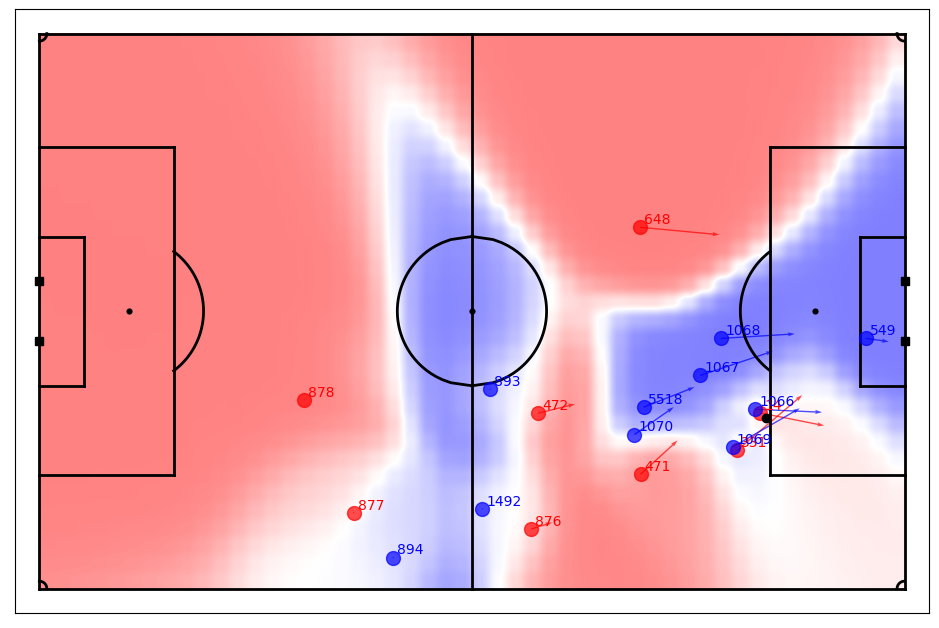

In [7]:
mviz.plot_pitch_control_for_frame(100, tracking_home, tracking_away, events, params)

In [45]:
l=0
for play in LR_data.play.unique():
    l+=len(LR_data.query("play==@play").frame.unique())

In [55]:
l

3549